In [1]:
import os

import numpy as np
import skimage.io
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import SimpleITK as sitk

from PIL import Image

from sklearn.metrics import f1_score, jaccard_score, confusion_matrix, recall_score
from skimage.morphology import disk, erosion, dilation
from skimage.measure import regionprops, label

In [2]:
def read_image(path):
    """Reads image from path and returns image array"""
    img = skimage.io.imread(path, as_gray=True)

    return np.expand_dims(img, axis=2)

def postprocessing(mask):
    '''This function enabels post processing based on binary mask.
    This consists of selecting the largest object (one_object) and a closing
    operation to fill the holes (closing)
    Input: binary mask
    Returns: Post processing mask (0,1)
    ''' 
    labels_mask = label(mask)                       
    regions = regionprops(labels_mask)
    regions.sort(key=lambda x: x.area, reverse=True)
    if len(regions) > 1:
      for rg in regions[1:]:
        labels_mask[rg.coords[:,0], rg.coords[:,1]] = 0
    labels_mask[labels_mask!=0] = 1
    mask = labels_mask
    
    if np.max(mask) == 255:
      mask = mask/255
    im_flood_fill = mask.copy()
    h, w = mask.shape[:2]
    overlay = np.zeros((h + 2, w + 2), np.uint8)
    im_flood_fill = im_flood_fill.astype("uint8")
    cv2.floodFill(im_flood_fill, overlay, (0, 0), 255)
    im_flood_fill_inv = cv2.bitwise_not(im_flood_fill)
    mask_out = mask | im_flood_fill_inv
    mask_out = mask_out/255
    return mask_out

def overlay(image, mask, color, alpha, resize=None):
    color = color[::-1]
    colored_mask = np.expand_dims(mask, 0).repeat(3, axis=0)
    colored_mask = np.moveaxis(colored_mask, 0, -1)
    masked = np.ma.MaskedArray(image, mask=colored_mask, fill_value=color)
    image_overlay = masked.filled()

    if resize is not None:
      image = cv2.resize(image.transpose(1, 2, 0), resize)
      image_overlay = cv2.resize(image_overlay.transpose(1, 2, 0), resize)

    image_combined = cv2.addWeighted(image, 1 - alpha, image_overlay, alpha, 0)
    return image_combined

def make_overlay(image, segmentation):
    se = disk(3)
    mask_dil = dilation(np.squeeze(segmentation), se)
    mask_ero = erosion(np.squeeze(segmentation), se)
    mask_border = np.logical_xor(mask_dil,mask_ero)*150
    image_3 = cv2.merge((image, image, image))
    image_with_mask = overlay(image_3, mask_border, color = (0,0,255), alpha=0.33)

    image_with_pred = Image.fromarray((image_with_mask))
    return image_with_pred

In [5]:
EXP_NUM = 7
EXP_NAME = 'experiment_' + f"{EXP_NUM:03}"
TEST = True
IMG_PATH = r"C:\Users\koenk\Documents\Master_Thesis\Data\Raw_data\images/"
IMG_TIMELAPSE_PATH = r"C:\Users\koenk\Documents\Master_Thesis\Data\Raw_data\Segmentation\new_data_2_F0/"
MASK_PATH = r"C:\Users\koenk\Documents\Master_Thesis\Data\Raw_data\mask/"
MODEL_PATH = r"C:\Users\koenk\Documents\Master_Thesis\Programming\Debugging\experiment_007 (1)/"
OUTPUT_PATH =  r"C:\Users\koenk\Documents\Master_Thesis\Programming\new_data_2_selection/"
N_FOLDS = 4

IMG_WIDTH = 800
IMG_HEIGHT = 800
IMG_CHANNELS = 1
IMG_PIXEL_SIZE = 0.34**2


# Create output directory for experiment
# check if path exists and create if not:
OUTPUT_FOLDER = os.path.join(OUTPUT_PATH, EXP_NAME)
if os.path.exists(OUTPUT_FOLDER):
    print('Experiment folder:', OUTPUT_FOLDER, 'exists.')
    # exit()
else:
    pass
OUTPUT_CURVE_FOLDER = OUTPUT_FOLDER + '/' + 'Thumbnails' + '/'
OUTPUT_IMAGE_FOLDER = OUTPUT_FOLDER + '/' + 'Segmented_images' + '/'
os.makedirs(OUTPUT_CURVE_FOLDER, exist_ok=True)


Experiment folder: C:\Users\koenk\Documents\Master_Thesis\Programming\new_data_2_selection/experiment_007 exists.


In [5]:
def build_unet_model(input_height, input_width, input_channels):
    # Define input layer
    inputs = tf.keras.layers.Input((input_height, input_width, input_channels))

    # Normalize input data
    normalized_inputs = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    # Down sampling path
    conv1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(normalized_inputs)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)
    conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)
    conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    pool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3)
    conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    pool4 = tf.keras.layers.MaxPooling2D((2, 2))(conv4)
    conv5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    pool5 = tf.keras.layers.MaxPooling2D((2, 2))(conv5)
    conv6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool5)

    # Upsampling path
    up7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    concat7 = tf.keras.layers.concatenate([up7, conv5])
    conv7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat7)
    up8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    concat8 = tf.keras.layers.concatenate([up8, conv4])
    conv8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat8)
    up9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    concat9 = tf.keras.layers.concatenate([up9, conv3])
    conv9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat9)
    up10 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv9)
    concat10 = tf.keras.layers.concatenate([up10, conv2])
    conv10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat10)
    up11 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv10)
    concat11 = tf.keras.layers.concatenate([up11, conv1], axis=3)
    conv11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(concat11)

    # Output layer
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv11)

    # Build the model
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    return model

def build_rd_unet(input_height, input_width, input_channels, print_summary=True):
    """Builds a Residual Dilated U-Net model"""

    # Define input layer
    inputs = tf.keras.layers.Input((input_height, input_width, input_channels))

    # Normalize input data
    normalized_inputs = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    # Down sampling path
    conv1 = tf.keras.layers.Conv2D(8, (3, 3),  activation='relu', kernel_initializer='he_normal', padding='same')(normalized_inputs)
    conv1 = tf.keras.layers.Conv2D(8, (3, 3),  activation=None, kernel_initializer='he_normal', padding='same')(conv1)
    skip1 = tf.keras.layers.Conv2D(8, (1, 1),  activation=None, kernel_initializer='he_normal', padding='same')(normalized_inputs)
    conv1 = tf.keras.layers.Add()([conv1, skip1])
    conv1 = tf.keras.layers.Activation('relu')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(16, (3, 3),  activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(16, (3, 3),  activation=None, kernel_initializer='he_normal', padding='same')(conv2)
    skip2 = tf.keras.layers.Conv2D(16, (1, 1),  activation=None, kernel_initializer='he_normal', padding='same')(pool1)
    conv2 = tf.keras.layers.Add()([conv2, skip2])
    conv2 = tf.keras.layers.Activation('relu')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(32, (3, 3),  activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(32, (3, 3),  activation=None, kernel_initializer='he_normal', padding='same')(conv3)
    skip3 = tf.keras.layers.Conv2D(32, (1, 1),  activation=None, kernel_initializer='he_normal', padding='same')(pool2)
    conv3 = tf.keras.layers.Add()([conv3, skip3])
    conv3 = tf.keras.layers.Activation('relu')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D((2, 2))(conv3)

    conv4 = tf.keras.layers.Conv2D(48, (3, 3),  activation='relu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv2D(48, (3, 3),  activation=None, kernel_initializer='he_normal', padding='same')(conv4)
    skip4 = tf.keras.layers.Conv2D(48, (1, 1),  activation=None, kernel_initializer='he_normal', padding='same')(pool3)
    conv4 = tf.keras.layers.Add()([conv4, skip4])
    conv4 = tf.keras.layers.Activation('relu')(conv4)
    pool4 = tf.keras.layers.MaxPooling2D((2, 2))(conv4)

    # bridge
    bridge1 = tf.keras.layers.Conv2D(64, (3, 3), dilation_rate=1, activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    bridge2 = tf.keras.layers.Conv2D(64, (3, 3), dilation_rate=2, activation='relu', kernel_initializer='he_normal', padding='same')(bridge1)
    bridge3 = tf.keras.layers.Conv2D(64, (3, 3), dilation_rate=4, activation='relu', kernel_initializer='he_normal', padding='same')(bridge2)
    bridge4 = tf.keras.layers.Conv2D(64, (3, 3), dilation_rate=8, activation='relu', kernel_initializer='he_normal', padding='same')(bridge3)
    bridge5 = tf.keras.layers.Conv2D(64, (3, 3), dilation_rate=16, activation='relu', kernel_initializer='he_normal', padding='same')(bridge4)
    bridge6 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(bridge5)

    # Upsampling path
    up8 = tf.keras.layers.UpSampling2D(size=(2, 2))(bridge6)
    up8 = tf.keras.layers.concatenate([up8, conv4])
    conv8 = tf.keras.layers.Conv2D(48, (3, 3),  activation='relu', kernel_initializer='he_normal', padding='same')(up8)
    conv8 = tf.keras.layers.Conv2D(48, (3, 3),  activation=None, kernel_initializer='he_normal', padding='same')(conv8)
    skip8 = tf.keras.layers.Conv2D(48, (1, 1),  activation=None, kernel_initializer='he_normal', padding='same')(up8)
    conv8 = tf.keras.layers.Add()([conv8, skip8])
    conv8 = tf.keras.layers.Activation('relu')(conv8)

    up9 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv8)

    up9 = tf.keras.layers.concatenate([up9, conv3])
    conv9 = tf.keras.layers.Conv2D(32, (3, 3),  activation='relu', kernel_initializer='he_normal', padding='same')(up9)
    conv9 = tf.keras.layers.Conv2D(32, (3, 3),  activation=None, kernel_initializer='he_normal', padding='same')(conv9)
    skip9 = tf.keras.layers.Conv2D(32, (1, 1),  activation=None, kernel_initializer='he_normal', padding='same')(up9)
    conv9 = tf.keras.layers.Add()([conv9, skip9])
    conv9 = tf.keras.layers.Activation('relu')(conv9)

    up10 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv9)

    up10 = tf.keras.layers.concatenate([up10, conv2])
    conv10 = tf.keras.layers.Conv2D(16, (3, 3),  activation='relu', kernel_initializer='he_normal', padding='same')(up10)
    conv10 = tf.keras.layers.Conv2D(16, (3, 3),  activation=None, kernel_initializer='he_normal', padding='same')(conv10)
    skip10 = tf.keras.layers.Conv2D(16, (1, 1),  activation=None, kernel_initializer='he_normal', padding='same')(up10)
    conv10 = tf.keras.layers.Add()([conv10, skip10])
    conv10 = tf.keras.layers.Activation('relu')(conv10)

    up11 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv10)

    up11 = tf.keras.layers.concatenate([up11, conv1])
    conv11 = tf.keras.layers.Conv2D(8, (3, 3),  activation='relu', kernel_initializer='he_normal', padding='same')(up11)
    conv11 = tf.keras.layers.Conv2D(8, (3, 3),  activation=None, kernel_initializer='he_normal', padding='same')(conv11)
    skip11 = tf.keras.layers.Conv2D(8, (1, 1),  activation=None, kernel_initializer='he_normal', padding='same')(up11)
    conv11 = tf.keras.layers.Add()([conv11, skip11])
    conv11 = tf.keras.layers.Activation('relu')(conv11)

    # Output layer
    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(conv11)

    # Build the model
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    if print_summary:
        print(model.summary())

    return model

In [7]:
for i_fold in range(N_FOLDS):

    # load trained model    
    model = build_rd_unet(input_height=IMG_HEIGHT, input_width=IMG_WIDTH, input_channels=IMG_CHANNELS)
    model.load_weights(MODEL_PATH + 'complete_model_' + str(i_fold+1) + '.h5')

    
    for folder in os.listdir(IMG_TIMELAPSE_PATH):
        OUTPUT_IMAGE_FOLDER_TEMP = OUTPUT_IMAGE_FOLDER + '/' + folder + '/' + f'fold_{i_fold+1}/'
        OUTPUT_CURVE_FOLDER_FOLD = OUTPUT_CURVE_FOLDER + '/' + f'fold_{i_fold+1}/'
        os.makedirs(OUTPUT_IMAGE_FOLDER_TEMP, exist_ok=True)
        os.makedirs(OUTPUT_CURVE_FOLDER_FOLD, exist_ok=True)
        
        if not os.path.isdir(IMG_TIMELAPSE_PATH + folder):
            continue
        # if int(folder[1:]) not in test_ids:
        #     continue

        test_fn_timelapse = sorted([file for file in os.listdir(IMG_TIMELAPSE_PATH + folder)])
       
        # Full timelapse data:
        test_images_timelapse = np.array([read_image(IMG_TIMELAPSE_PATH + folder + '/' + file) for file in test_fn_timelapse])
        
        # Sample images:
        idx = np.round(np.linspace(0, len(test_images_timelapse) - 1, 10)).astype(int)
        test_images_timelapse_sample = test_images_timelapse[idx]


        # # Predictions:
        test_predictions = model.predict(test_images_timelapse_sample, batch_size=8)
        test_predictions_thresholded = test_predictions > 0.5

        # Post-process the predictions:
        test_predictions_thresholded = np.array([postprocessing(np.squeeze(img)) for img in test_predictions_thresholded])

        images_overlay = np.array([make_overlay(np.squeeze(img), np.squeeze(pred)) for img, pred in zip(test_images_timelapse_sample, test_predictions_thresholded)])

        # # Save the predictions:
        spacing = [0.0034, 0.0034, 1.0]
        images = sitk.GetImageFromArray(test_images_timelapse_sample)
        masks = sitk.GetImageFromArray(test_predictions_thresholded)
        images.SetSpacing(spacing)
        masks.SetSpacing(spacing)

        # # Set up the image properties (origin, direction, etc.)
        images.SetOrigin([0.0, 0.0, 0.0])
        masks.SetOrigin([0.0, 0.0, 0.0])
        images.SetDirection([1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1])
        masks.SetDirection([1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,1])

        # # Create a NIfTI image writer
        writer = sitk.ImageFileWriter()

        # # Set the output file name with a .nii extension
        output_filename = f"{OUTPUT_IMAGE_FOLDER_TEMP}/{folder}_full_segmentation_{i_fold+1}.nii"
        writer.SetFileName(output_filename)

        # # Execute the writer
        try:
            writer.Execute(masks)
            print(f"Image successfully written to {output_filename}")
        except Exception as e:
            print(f"Error: {e}")

        output_filename = f"{OUTPUT_IMAGE_FOLDER_TEMP}/{folder}_image_sample_{i_fold+1}.nii"
        writer.SetFileName(output_filename)

        # # Execute the writer
        try:
            writer.Execute(images)
            print(f"Image successfully written to {output_filename}")
        except Exception as e:
            print(f"Error: {e}")
        
        fig, ax = plt.subplots(4, 3, figsize=(5, 7))
        for i in range(10):
            ax[i//3, i%3].imshow(images_overlay[i])
            ax[i//3, i%3].axis('off')
        
        # remove empty plots
        for i in range(10, 12):
            ax[i//3, i%3].axis('off')
        plt.suptitle(f'{folder}, fold {i_fold+1}')
        plt.tight_layout()

        fig.savefig(OUTPUT_CURVE_FOLDER_FOLD + f'{folder}_segmentation_{i_fold+1}.png', dpi=300)
        plt.close()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 800, 800, 1  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 800, 800, 1)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_31 (Conv2D)             (None, 800, 800, 8)  80          ['lambda_1[0][0]']               
                                                                                                  
 conv2d_32 (Conv2D)             (None, 800, 800, 8)  584         ['conv2d_31[0][0]']        

In [8]:
embryo_dict = dict()
embryo_new_idx = 38

for folder in os.listdir(IMG_TIMELAPSE_PATH):
    test_fn_timelapse = sorted([file for file in os.listdir(IMG_TIMELAPSE_PATH + folder)])
    
    base_name = '_'.join(test_fn_timelapse[0].split('_')[:5])
    print(base_name)
   
    # Sample images:
    idx = np.round(np.linspace(0, len(test_fn_timelapse) - 1, 10)).astype(int)
    
    embryo_dict[base_name] = list(np.array([f'E{embryo_new_idx}_' + file[-7:-4] for file in test_fn_timelapse])[idx])
    embryo_new_idx += 1
    # print(np.array(test_fn_timelapse)[idx])
    

D2022.08.20_S01145_I4276_P_WELL03
D2022.08.22_S01149_I4276_P_WELL01
D2022.08.23_S01150_I4276_P_WELL11
D2022.08.24_S01153_I4276_P_WELL12
D2022.08.24_S01154_I4276_P_WELL10
D2022.08.24_S01155_I4276_P_WELL02
D2022.08.24_S01156_I4276_P_WELL10
D2022.08.25_S01157_I4276_P_WELL03
D2022.08.25_S01159_I4276_P_WELL05
D2022.08.27_S01164_I4276_P_WELL01
D2022.08.28_S01167_I4276_P_WELL04
D2022.09.01_S01171_I4276_P_WELL03
D2022.09.02_S01173_I4276_P_WELL01
D2022.09.02_S01176_I4276_P_WELL01
D2022.09.02_S01179_I4276_P_WELL02
D2022.09.05_S01181_I4276_P_WELL07


In [9]:
embryo_dict

{'D2022.08.20_S01145_I4276_P_WELL03': ['E38_502',
  'E38_519',
  'E38_536',
  'E38_553',
  'E38_570',
  'E38_588',
  'E38_605',
  'E38_622',
  'E38_639',
  'E38_656'],
 'D2022.08.22_S01149_I4276_P_WELL01': ['E39_538',
  'E39_550',
  'E39_562',
  'E39_575',
  'E39_587',
  'E39_599',
  'E39_611',
  'E39_624',
  'E39_636',
  'E39_648'],
 'D2022.08.23_S01150_I4276_P_WELL11': ['E40_423',
  'E40_437',
  'E40_450',
  'E40_464',
  'E40_478',
  'E40_491',
  'E40_505',
  'E40_519',
  'E40_532',
  'E40_546'],
 'D2022.08.24_S01153_I4276_P_WELL12': ['E41_496',
  'E41_502',
  'E41_508',
  'E41_514',
  'E41_520',
  'E41_525',
  'E41_531',
  'E41_537',
  'E41_543',
  'E41_549'],
 'D2022.08.24_S01154_I4276_P_WELL10': ['E42_535',
  'E42_548',
  'E42_561',
  'E42_574',
  'E42_587',
  'E42_600',
  'E42_613',
  'E42_626',
  'E42_639',
  'E42_652'],
 'D2022.08.24_S01155_I4276_P_WELL02': ['E43_554',
  'E43_565',
  'E43_575',
  'E43_586',
  'E43_596',
  'E43_607',
  'E43_617',
  'E43_628',
  'E43_638',
  'E43

In [12]:
import shutil
from PIL import Image, ImageSequence

RAW_SEG_PATH = r"C:\Users\koenk\Documents\Master_Thesis\Programming\new_data_2_selection\experiment_007\Refined_segmentations\Output_3d"
PROCESSED_SEG_PATH = r"C:\Users\koenk\Documents\Master_Thesis\Programming\new_data_2_selection\experiment_007\Refined_segmentations\processed_data\mask"
PROCESSED_IMG_PATH = r"C:\Users\koenk\Documents\Master_Thesis\Programming\new_data_2_selection\experiment_007\Refined_segmentations\processed_data\images"

os.makedirs(PROCESSED_SEG_PATH, exist_ok=True)
os.makedirs(PROCESSED_IMG_PATH, exist_ok=True)

for file in os.listdir(RAW_SEG_PATH):
    base_name = '_'.join(file.split('_')[:5])
    if base_name in embryo_dict:
        im = Image.open(os.path.join(RAW_SEG_PATH, file))
        for i, page in enumerate(ImageSequence.Iterator(im)):
            skimage.io.imsave(os.path.join(PROCESSED_SEG_PATH, embryo_dict[base_name][i] + '.tif'), np.array(page, dtype=np.uint8)*255)

            # copy and process original image
            shutil.copy2(os.path.join(IMG_TIMELAPSE_PATH, base_name, base_name + '_RUN' + embryo_dict[base_name][i][4:] + '.JPG'), os.path.join(PROCESSED_IMG_PATH, embryo_dict[base_name][i] + '.JPG'))


In [26]:
from PIL import Image, ImageSequence

im = Image.open(r"C:\Users\koenk\Documents\Master_Thesis\Programming\new_data_selection\experiment_007\Refined_segmentations\Output_3d\D2023.12.14_S00168_I4927_P_WELL05_full_segmentation_3-Segment_1-label.tif")

for i, page in enumerate(ImageSequence.Iterator(im)):
    np.array(page).shape

In [62]:
embryo_dict

{'D2023.10.24_S00067_I4928_P_WELL03': ['E23_590',
  'E23_600',
  'E23_610',
  'E23_620',
  'E23_630',
  'E23_641',
  'E23_651',
  'E23_661',
  'E23_671',
  'E23_681'],
 'D2023.11.28_S00135_I4928_P_WELL02': ['E24_526',
  'E24_545',
  'E24_565',
  'E24_584',
  'E24_604',
  'E24_623',
  'E24_643',
  'E24_662',
  'E24_682',
  'E24_701'],
 'D2023.11.29_S00149_I4927_P_WELL03': ['E25_538',
  'E25_556',
  'E25_574',
  'E25_592',
  'E25_610',
  'E25_628',
  'E25_646',
  'E25_664',
  'E25_682',
  'E25_700'],
 'D2023.12.01_S00151_I4927_P_WELL03': ['E26_546',
  'E26_563',
  'E26_580',
  'E26_597',
  'E26_614',
  'E26_631',
  'E26_648',
  'E26_665',
  'E26_682',
  'E26_699'],
 'D2023.12.01_S02077_I4276_P_WELL08': ['E27_555',
  'E27_566',
  'E27_577',
  'E27_587',
  'E27_598',
  'E27_609',
  'E27_620',
  'E27_630',
  'E27_641',
  'E27_652'],
 'D2023.12.02_S02078_I4276_P_WELL07': ['E28_471',
  'E28_478',
  'E28_486',
  'E28_493',
  'E28_500',
  'E28_508',
  'E28_515',
  'E28_522',
  'E28_530',
  'E28

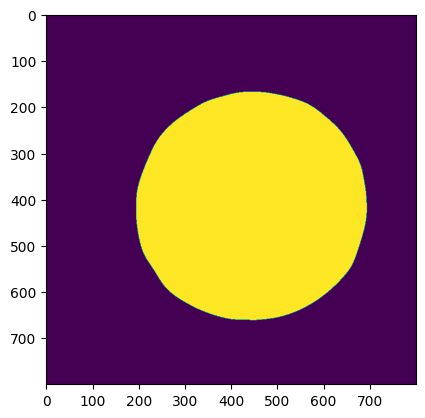

In [28]:
plt.imshow(np.array(page))

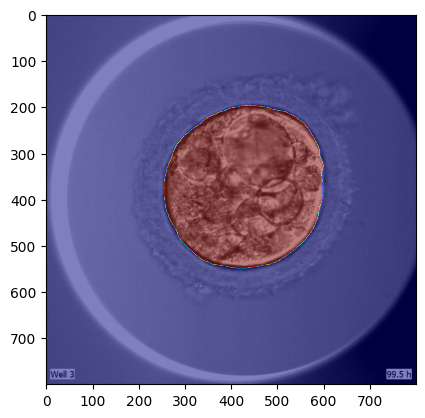

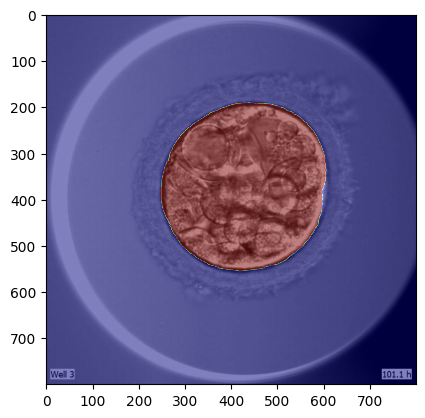

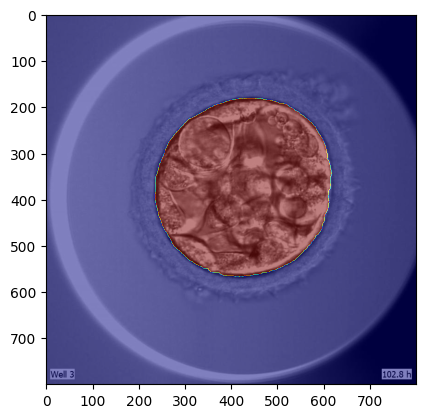

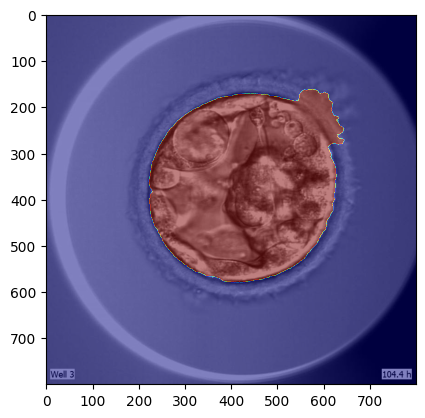

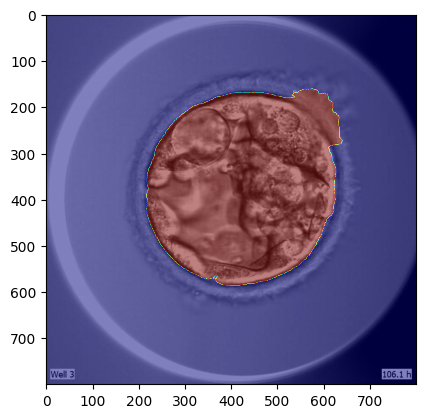

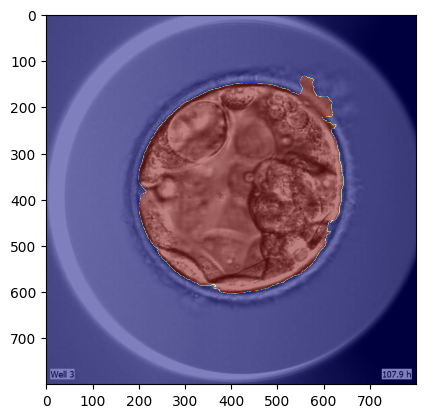

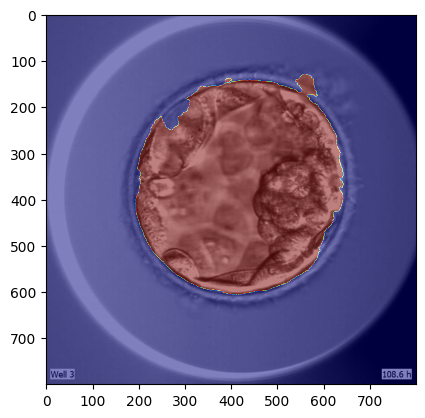

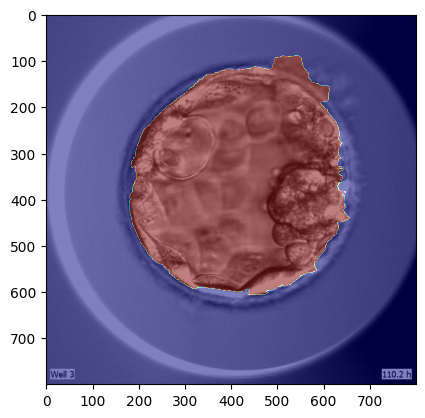

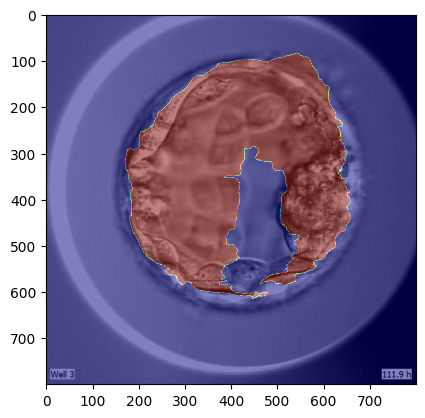

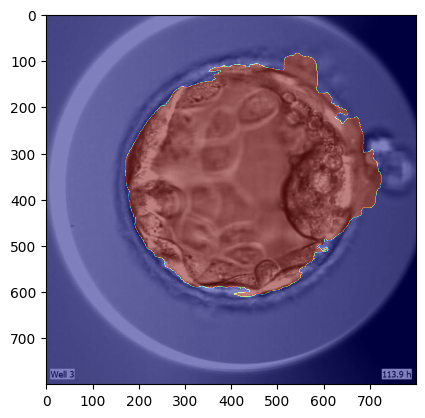

In [ ]:
for i in range(len(test_images_timelapse_sample)):
    plt.imshow(np.squeeze(test_images_timelapse_sample[i]), cmap='gray')
    plt.imshow(np.squeeze(test_predictions_thresholded[i]), cmap='jet', alpha=0.5)
    plt.show()
    